In [1]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
from data import *
from config import *
from classifer import *
from classifier_shapelet import *
from describer import *
print("using device: ", device)
random_state = 333
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# for debugging
# import importlib
# import models
# importlib.reload(models)


Random seed set to 333
using device:  cpu


In [3]:
# # -----------------Train Data-----------------
# df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
# df.columns = df.columns.astype(str)
# df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
# df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
# df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
# df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
# df = label_death7d(df, df_y, id_col='VitalID')
# df = df.merge(df_demo, on='VitalID', how='left')
# df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
# df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
# df = text_gen_input_column(df, config_dict['text_config'])
# df['rowid'] = df.index.to_series() 
# df_train = df

# # -----------------Test Data-----------------
# df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
# df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
# df_test.columns = df_test.columns.astype(str)
# df_test = label_death7d(df_test, df_y_test, id_col='TestID')
# df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
# df_test = df_test.merge(df_demo_test, on='TestID', how='left')
# df_test['rowid'] = df_test.index.to_series()
# df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
# df_test['VitalTime'] = df_test['VitalTime'].astype(int)
# rename_dict = {'TestID': 'VitalID'}
# df_test = df_test.rename(columns=rename_dict)

# df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
# df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
# df_test = text_gen_input_column(df_test, config_dict['text_config'])
# df_test_org = df_test[df.columns]
# df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 

In [4]:
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']
y_col = 'cl_event'
# # ---- downsample negative class(es) ----
# # sample 5000 rows from df_test[df_test[y_col]==txt_ls_org[1]], without replacement
# neg_sample_size = 300
# df_test_downsampled = df_test[df_test[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
# df_test = pd.concat([df_test[df_test[y_col]==txt_ls_org[0]], df_test_downsampled])
# df_train_downsampled = df_train[df_train[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
# df_train = pd.concat([df_train[df_train[y_col]==txt_ls_org[0]], df_train_downsampled])

# # ---- augment + balance train data----
# target_event_rate = len(df_test[df_test[y_col]==txt_ls_org[0]])/len(df_test)
# max_size = int(target_event_rate*len(df_train))
# if config_dict['ts_aug']:
#     df_train = augment_balance_data(df_train, 
#                                     txt_ls_org, 
#                                     y_col, 
#                                     config_dict, 
#                                     pretrained_model_path='./pretrained/hr_vae_linear_medium.pth', 
#                                     K=10,
#                                     max_size=max_size)


# # ---- block or not ----
# # important for generating labels for block target
# df_train = df_train.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)
# if not config_dict['block_target']:
#     df_train['label'] = df_train.index.to_series()
#     df_test['label'] = df_test.index.to_series()
# else:
#     df_train['label'] = df_train['rowid'].astype(int)
#     df_test['label'] = df_test['rowid'].astype(int)


df_train = pd.read_csv("./results/train_shapelet.csv")
df_test = pd.read_csv("./results/test_shapelet.csv")

# ---- prepare for binary classification evaluation ----
def get_y_true_and_ts_df(df_new, txt_ls_org):
    df_new_y = pd.get_dummies(df_new['cl_event'])
    df_new_y = df_new_y[txt_ls_org]
    y_true = torch.tensor(df_new_y.values)
    ts_df = df_new.loc[:,'1':'300']
    return y_true, ts_df

y_true_train, ts_df_train = get_y_true_and_ts_df(df_train, txt_ls_org)     # create y_true_train and ts_df_train
y_true_test, ts_df_test = get_y_true_and_ts_df(df_test, txt_ls_org)     # create y_true_test and ts_df_test
print(ts_df_train.shape)
print(ts_df_test.shape)


y_true_train = y_true_train.float()
y_true_test = y_true_test.float() 
train_loader = prepare_basedata(ts_df_train, y_true_train)
test_loader = prepare_basedata(ts_df_test, y_true_test)

# get number of positives in y_true_train
pos_count = (y_true_train[:,0] == 1).sum().item()
print(f"Number of positives in y_true_train: {pos_count}")

# get number of positives in y_true_test
pos_count = (y_true_test[:,0] == 1).sum().item()
print(f"Number of positives in y_true_test: {pos_count}")



X_train = np.array(ts_df_train) # nobs x 300
y_train = np.array(y_true_train[:,0])# nobs ,
X_test = np.array(ts_df_test) # nobs x 300
y_test = np.array(y_true_test[:,0])# nobs ,


(100, 300)
(100, 300)
Number of positives in y_true_train: 50
Number of positives in y_true_test: 50


# shapelet models to predict clinical outcomes end2end

In [5]:
# find number of jobs available
n_jobs = os.cpu_count() - 4

clf = FastShapeletClassifier(
    min_length=50,    # 1 minute
    max_length=200,   # 2 minutes
    step_size=50,
    n_shapelets=5,
    n_jobs=n_jobs#
)
clf.fit(X_train, y_train)

Extracting candidates...
Evaluating 60300 shapelets in parallel...


Finding shapelets: 100%|██████████| 60300/60300 [15:26<00:00, 65.11it/s]


Selecting top shapelets...
Training classifier...


Accuracy: 0.8600, F1 Score: 0.8571, AUC: 0.9236


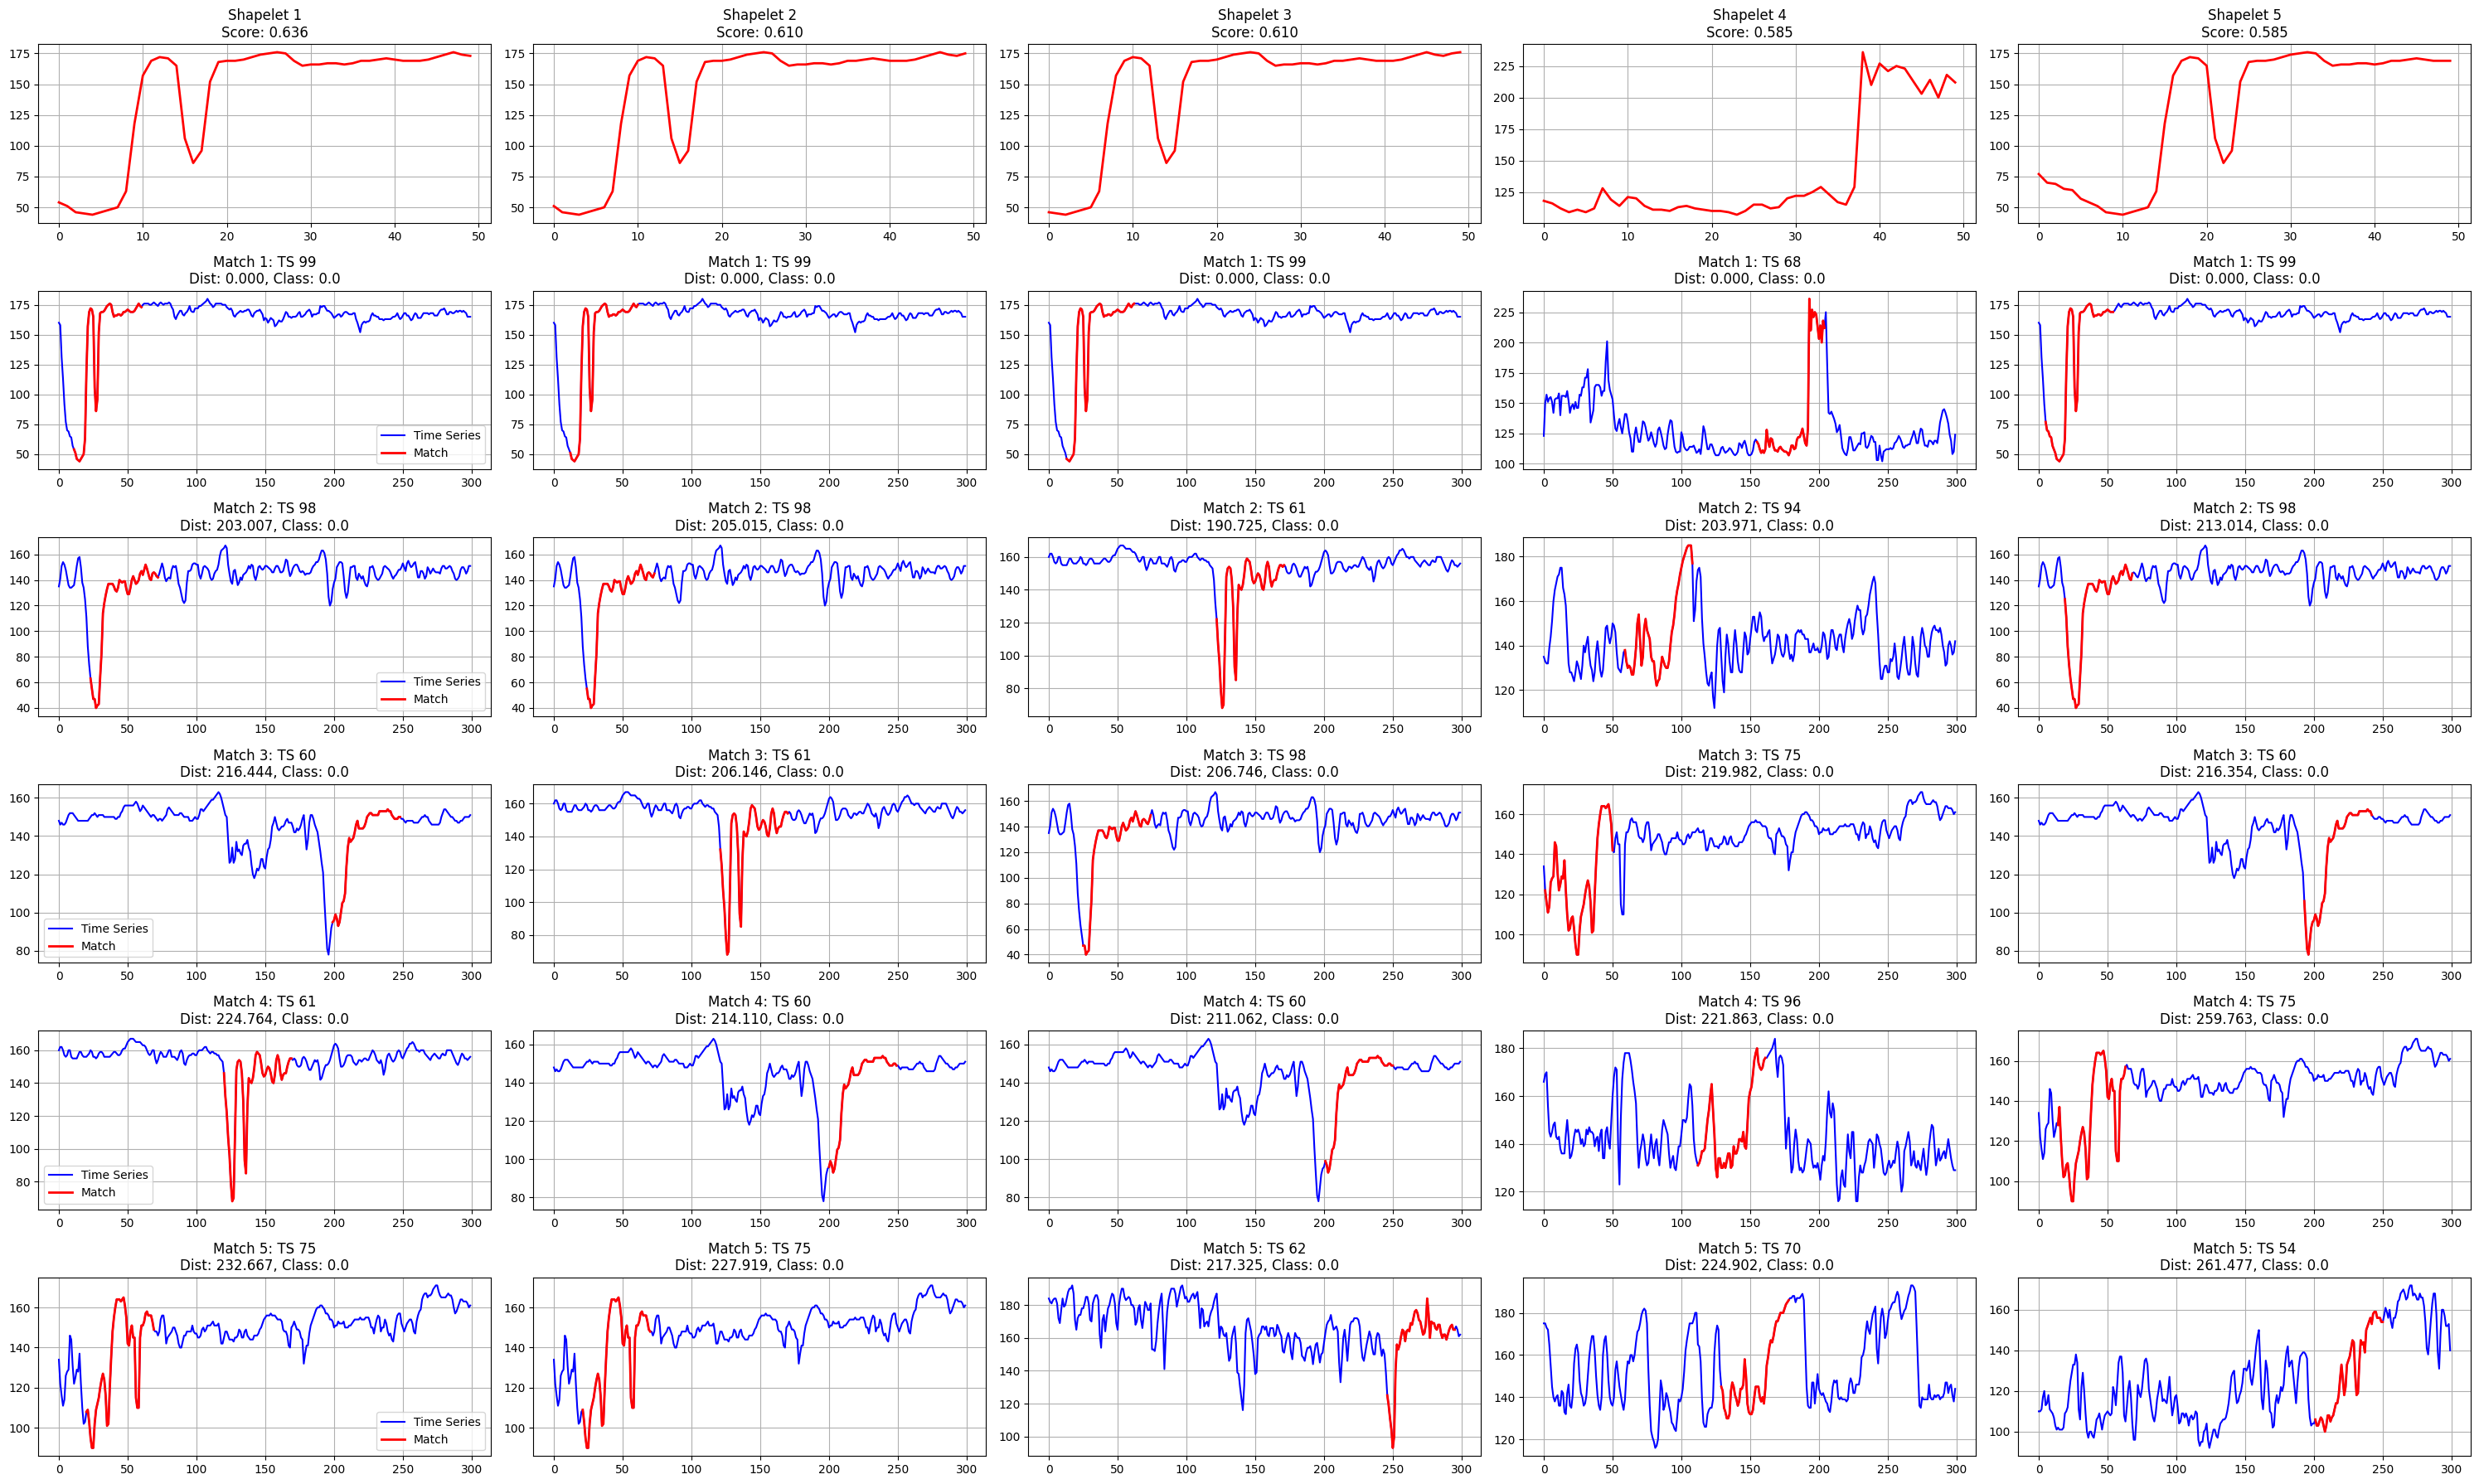

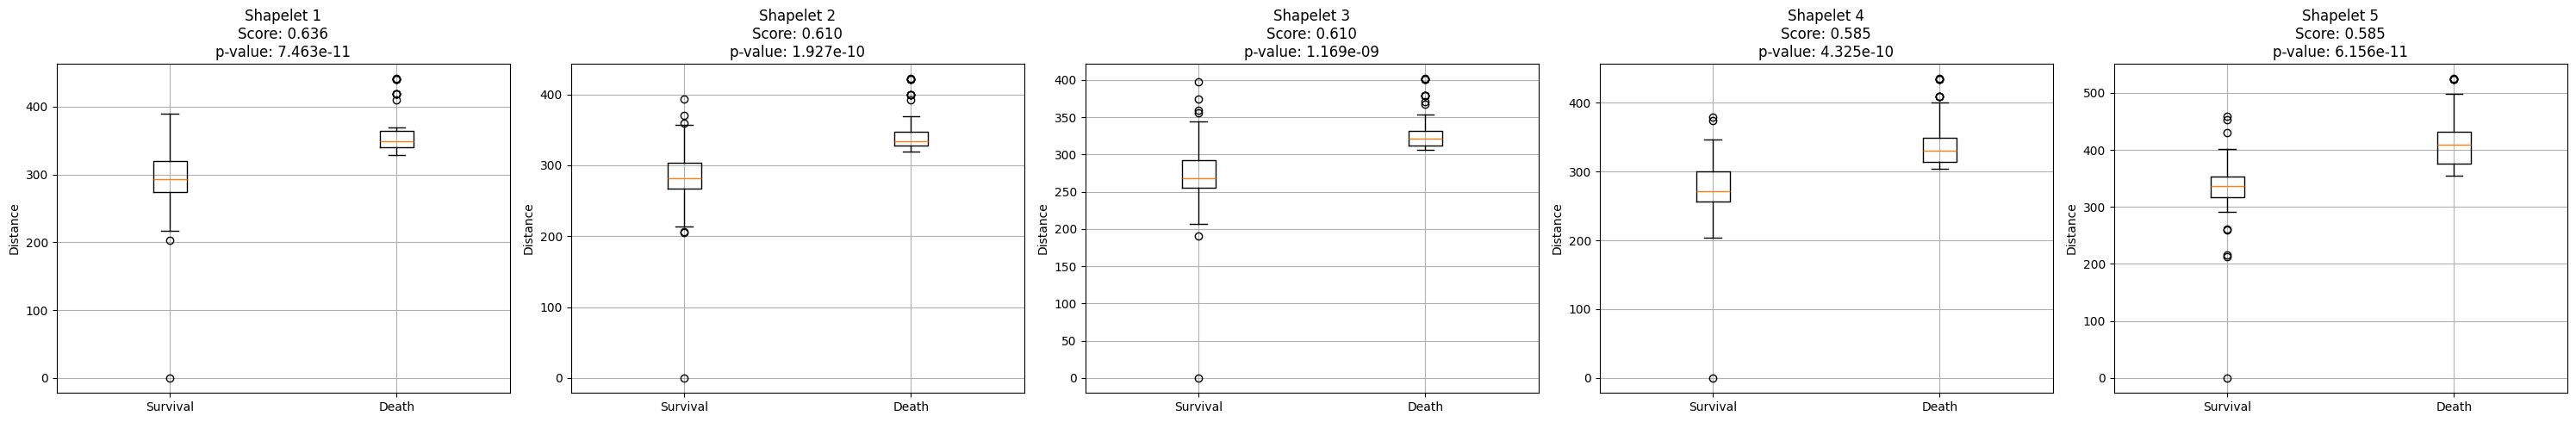

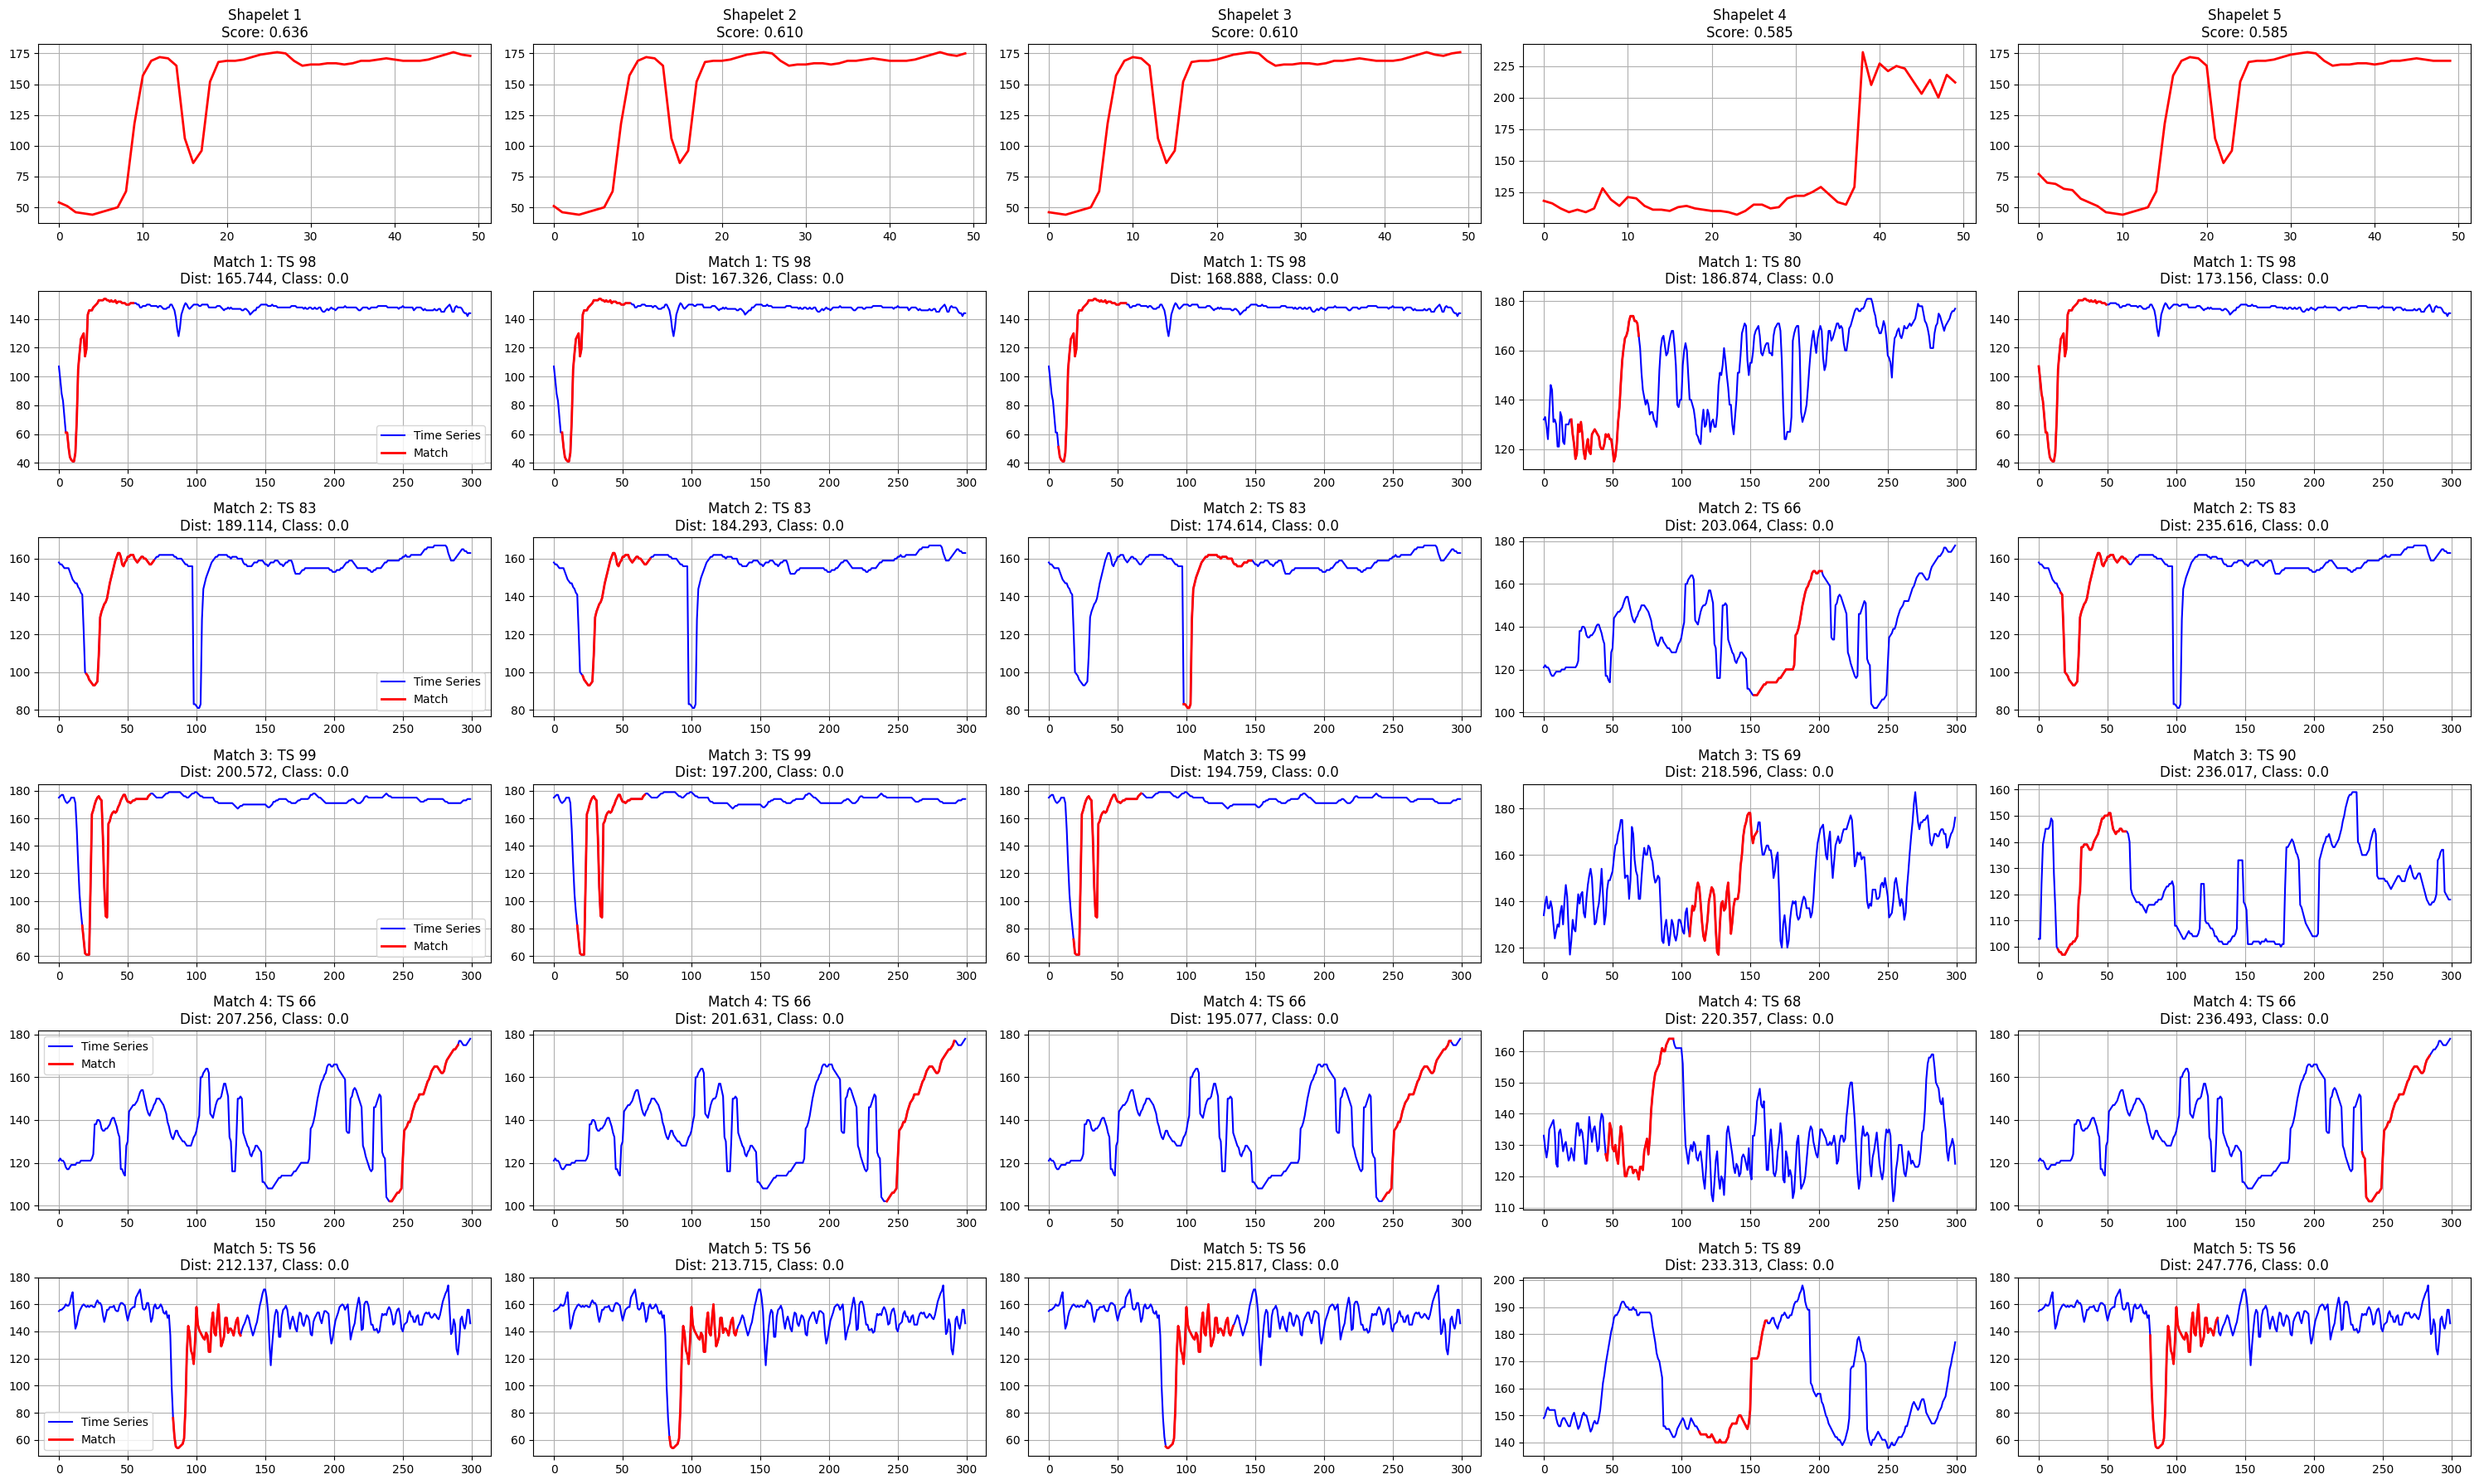

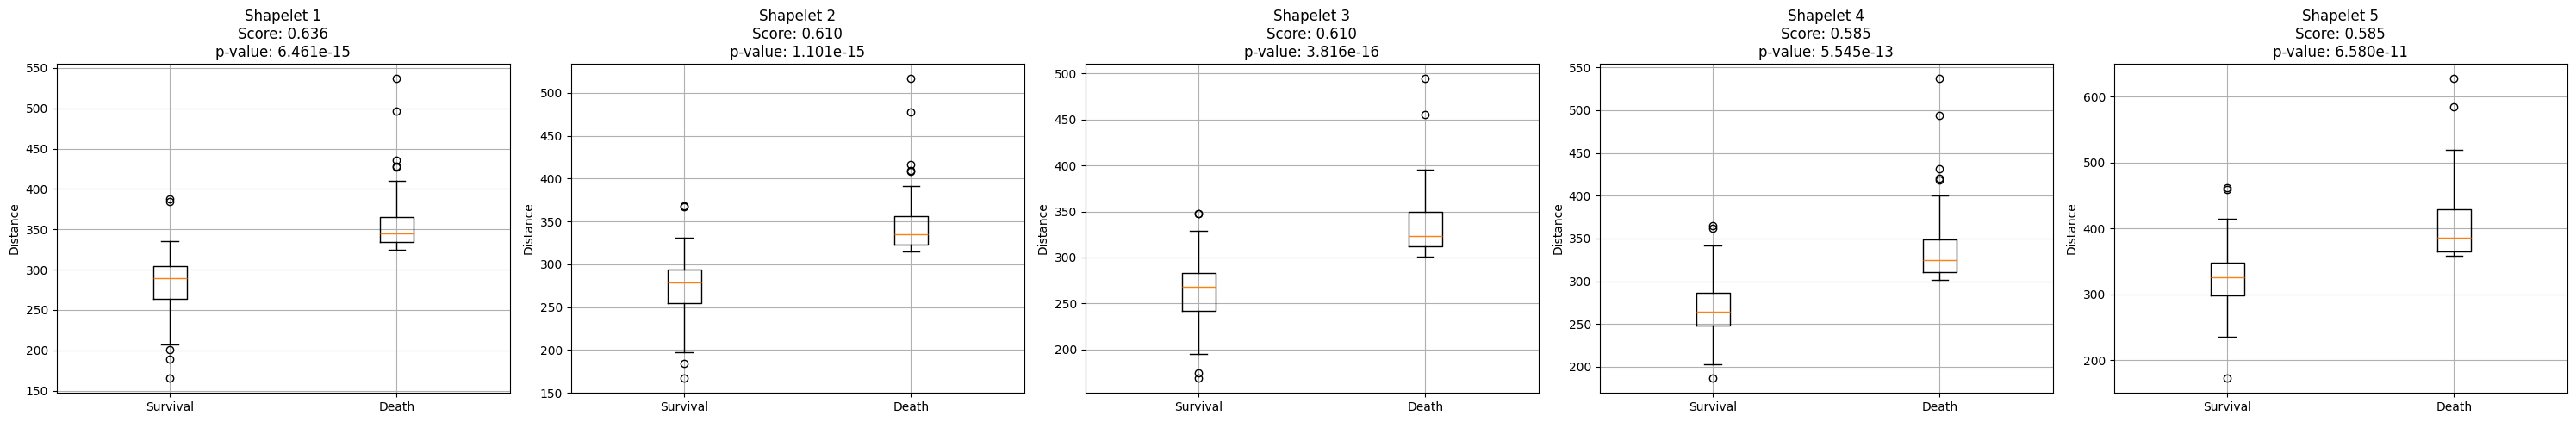

In [6]:

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)


# Get performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob[:,1])
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")
# Get learned shapelets
shapelets = clf.get_shapelets()

plot_all_shapelet_matches_grid(clf, X_train, y_train, n_matches=5)
shapelet_metrics = analyze_shapelet_discrimination(clf, X_train, y_train)
plot_all_shapelet_matches_grid(clf, X_test, y_test, n_matches=5)
shapelet_metrics = analyze_shapelet_discrimination(clf, X_test, y_test)